# Enhanced Baseline Comparison with Statistical Validation

**Purpose:** Comprehensive comparison between trained Q-Learning agent and fixed-time baseline with statistical significance tests.

**Improvements over basic version:**
- Statistical significance testing (t-test, p-values)
- Multiple performance metrics (waiting time, throughput, queue length, reward)
- Confidence intervals (95%)
- Exportable results for thesis
- Professional visualizations

## 1. Import Libraries

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

sys.path.append(os.path.abspath(os.path.join('..')))

from src.simulation.environment import JammingMachine
from src.agent.q_learning_agent import QLearningAgent

## 2. Configuration

In [2]:
# Paths
SIM_CONFIG_PATH = "../config/sim_config.json"
Q_TABLE_PATH = "../trained_q_table.json"
LOG_FILE_PATH = "../training_log.json"

# Evaluation parameters
NUM_EVALUATION_EPISODES = 100  # Increased for better statistical validity
CONFIDENCE_LEVEL = 0.95  # For confidence intervals

# Output
RESULTS_OUTPUT_DIR = "../results"
os.makedirs(RESULTS_OUTPUT_DIR, exist_ok=True)

print(f"Configuration loaded. Will run {NUM_EVALUATION_EPISODES} evaluation episodes.")

Configuration loaded. Will run 100 evaluation episodes.


## 3. Analyze Training Progress

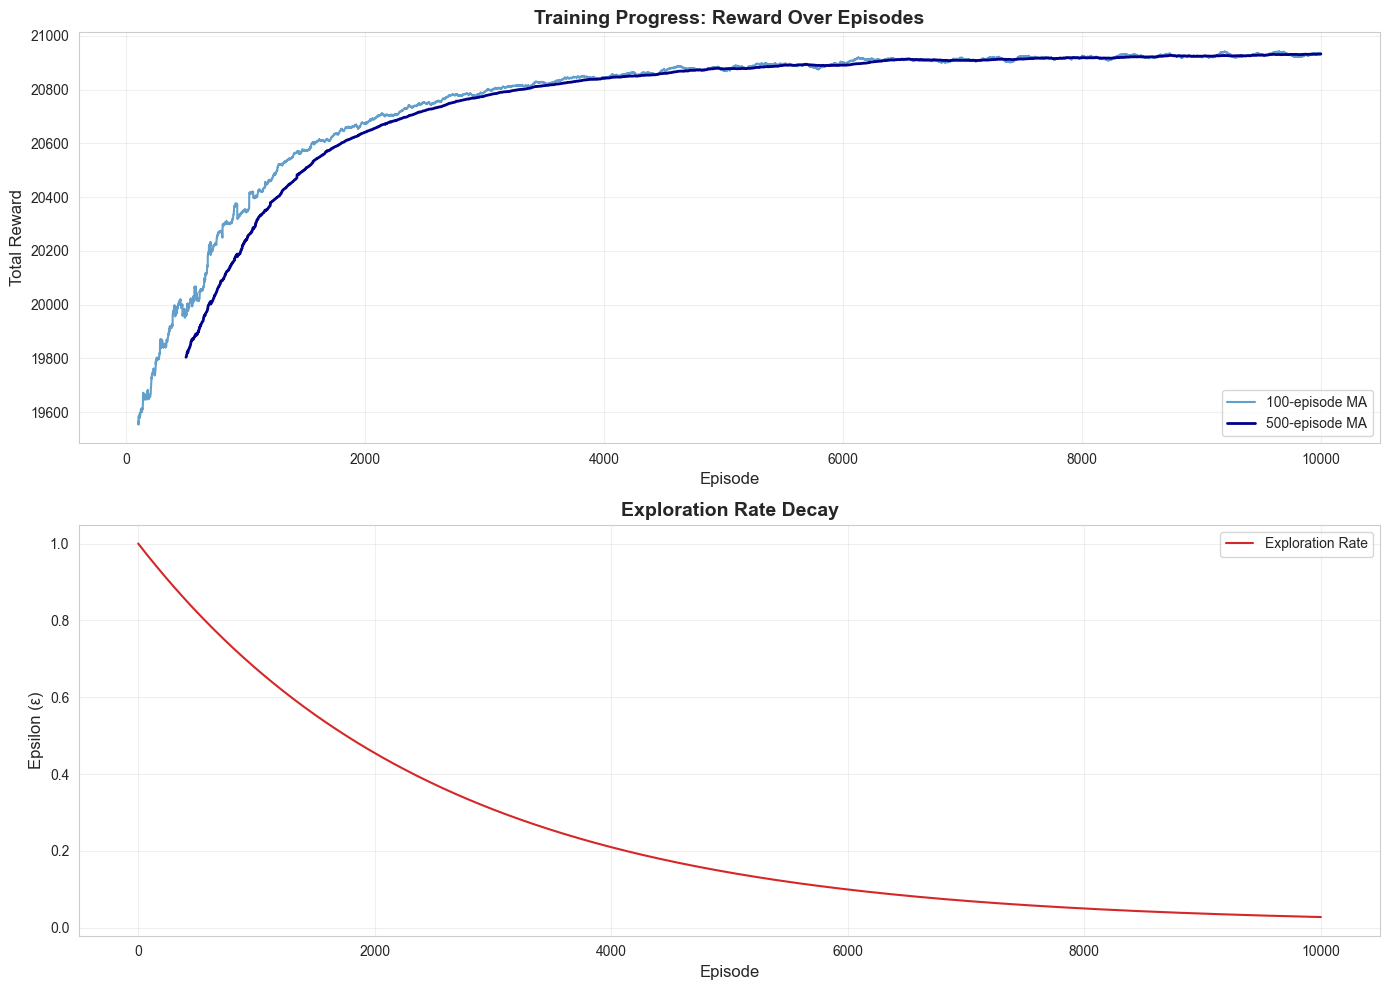


=== TRAINING STATISTICS ===
Total Episodes: 10000
Initial Reward: 19556.50
Final Reward: 20936.20
Best Episode Reward: 21092.96
Final Epsilon: 0.0281
Improvement: 7.05%


In [3]:
try:
    log_df = pd.read_json(LOG_FILE_PATH)
    
    # Calculate moving averages
    log_df['reward_ma_100'] = log_df['total_reward'].rolling(window=100).mean()
    log_df['reward_ma_500'] = log_df['total_reward'].rolling(window=500).mean()
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Reward progression
    ax1.plot(log_df['episode'], log_df['reward_ma_100'], 
             color='tab:blue', linewidth=1.5, label='100-episode MA', alpha=0.7)
    ax1.plot(log_df['episode'], log_df['reward_ma_500'], 
             color='darkblue', linewidth=2, label='500-episode MA')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Training Progress: Reward Over Episodes', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Epsilon decay
    ax2.plot(log_df['episode'], log_df['epsilon'], 
             color='tab:red', linewidth=1.5, label='Exploration Rate')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Epsilon (ε)', fontsize=12)
    ax2.set_title('Exploration Rate Decay', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_OUTPUT_DIR}/training_progress.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print training statistics
    print("\n=== TRAINING STATISTICS ===")
    print(f"Total Episodes: {len(log_df)}")
    print(f"Initial Reward: {log_df['total_reward'].iloc[:100].mean():.2f}")
    print(f"Final Reward: {log_df['total_reward'].iloc[-100:].mean():.2f}")
    print(f"Best Episode Reward: {log_df['total_reward'].max():.2f}")
    print(f"Final Epsilon: {log_df['epsilon'].iloc[-1]:.4f}")
    print(f"Improvement: {((log_df['total_reward'].iloc[-100:].mean() - log_df['total_reward'].iloc[:100].mean()) / log_df['total_reward'].iloc[:100].mean() * 100):.2f}%")
    print("="*30)

except FileNotFoundError:
    print(f"Log file not found at {LOG_FILE_PATH}. Please run training first.")

## 4. Load Environment and Trained Agent

In [4]:
# Load configuration and initialize environment
with open(SIM_CONFIG_PATH) as f:
    sim_config = json.load(f)

env = JammingMachine(sim_config)

# Load trained Q-Learning agent (no exploration during evaluation)
trained_agent = QLearningAgent(
    state_space_size=8,
    action_space_size=6,
    learning_rate=0,  # No learning during evaluation
    discount_factor=0.95,
    exploration_rate=0  # Pure exploitation
)
trained_agent.load_q_table(Q_TABLE_PATH)

print("✓ Environment and trained agent loaded successfully.")
print(f"  State space size: 8")
print(f"  Action space size: 6")
print(f"  Q-table entries: {len(trained_agent.q_table)}")

TrafficModel initialized.
RewardCalculator initialized with weights:
  Throughput: 0.45
  Queue:      0.30
  Waiting:    0.15
  Fairness:   0.10
Jamming Machine environment initialized.
QLearningAgent initialized with 5 bins.
State space size: 5^8 = 390,625 possible states
Q-table successfully loaded from ../trained_q_table.json
Loaded 379 states
✓ Environment and trained agent loaded successfully.
  State space size: 8
  Action space size: 6
  Q-table entries: 379


## 5. Define Baseline Fixed-Time Agent

In [5]:
class FixedTimeAgent:
    """
    Traditional fixed-time traffic signal controller.
    Cycles through predetermined signal phases with fixed durations.
    
    Action sequence:
    - Action 1: Normal NS (Green for North-South)
    - Action 4: Normal EW (Green for East-West)
    
    Each phase lasts 30 simulation steps (equivalent to 30 seconds).
    """
    def __init__(self, action_sequence=[1, 4], steps_per_action=30):
        self.action_sequence = action_sequence
        self.steps_per_action = steps_per_action
        self.current_step = 0
        self.action_index = 0
        
    def choose_action(self, state):
        """Choose action based on fixed timing, ignoring traffic state."""
        if self.current_step > 0 and self.current_step % self.steps_per_action == 0:
            self.action_index = (self.action_index + 1) % len(self.action_sequence)
        self.current_step += 1
        return self.action_sequence[self.action_index]
    
    def reset(self):
        """Reset agent state for new episode."""
        self.current_step = 0
        self.action_index = 0

baseline_agent = FixedTimeAgent()
print("✓ Baseline fixed-time agent initialized.")
print(f"  Phase sequence: {baseline_agent.action_sequence}")
print(f"  Phase duration: {baseline_agent.steps_per_action} steps")

✓ Baseline fixed-time agent initialized.
  Phase sequence: [1, 4]
  Phase duration: 30 steps


## 6. Enhanced Evaluation Function

In [6]:
def evaluate_agent_comprehensive(agent, environment, num_episodes, agent_name="Agent"):
    """
    Comprehensive evaluation with multiple performance metrics.
    
    Metrics collected:
    - Total reward per episode
    - Average queue length
    - Total vehicles departed (throughput)
    - Average reward per vehicle
    """
    print(f"\nEvaluating {agent_name}...")
    
    results = {
        'rewards': [],
        'queue_lengths': [],
        'throughputs': [],
        'avg_reward_per_vehicle': []
    }
    
    for episode in range(num_episodes):
        if (episode + 1) % 20 == 0:
            print(f"  Progress: {episode + 1}/{num_episodes} episodes")
        
        # Reset environment and agent
        state = environment.reset()
        if hasattr(agent, 'reset'):
            agent.reset()
        
        done = False
        episode_reward = 0
        queue_samples = []
        
        while not done:
            action = agent.choose_action(state)
            state, reward, done, info = environment.step(action)
            
            # Collect metrics
            episode_reward += reward
            queue_samples.append(sum(environment.vehicle_counts.values()))
        
        # Store episode results
        results['rewards'].append(episode_reward)
        results['queue_lengths'].append(np.mean(queue_samples))
        results['throughputs'].append(info.get('total_departed', 0))
        
        # Calculate average reward per vehicle if throughput > 0
        throughput = info.get('total_departed', 1)
        if throughput > 0:
            results['avg_reward_per_vehicle'].append(episode_reward / throughput)
        else:
            results['avg_reward_per_vehicle'].append(0)
    
    print(f"✓ {agent_name} evaluation complete.")
    return results

print("✓ Evaluation function ready.")

✓ Evaluation function ready.


## 7. Run Comprehensive Evaluation

In [7]:
print("\n" + "="*50)
print("STARTING COMPREHENSIVE EVALUATION")
print("="*50)

# Evaluate both agents
rl_results = evaluate_agent_comprehensive(trained_agent, env, NUM_EVALUATION_EPISODES, "Q-Learning Agent")
baseline_results = evaluate_agent_comprehensive(baseline_agent, env, NUM_EVALUATION_EPISODES, "Fixed-Time Baseline")

print("\n✓ All evaluations complete!")


STARTING COMPREHENSIVE EVALUATION

Evaluating Q-Learning Agent...

[Reward Breakdown]
  Throughput:   0.00 (weight: 0.45) =   0.00
  Queue:       95.00 (weight: 0.30) =  28.50
  Waiting:     97.50 (weight: 0.15) =  14.62
  Fairness:    97.50 (weight: 0.10) =   9.75
  TOTAL:       52.88

[DEBUG Step 1]
  Departed: 0
  Queues: {'North': 3, 'South': 2, 'East': 2, 'West': 3}
  Waiting times: {'North': 3, 'South': 2, 'East': 2, 'West': 3}
  Reward: 52.88

[Reward Breakdown]
  Throughput:  25.00 (weight: 0.45) =  11.25
  Queue:       93.00 (weight: 0.30) =  27.90
  Waiting:     96.50 (weight: 0.15) =  14.47
  Fairness:    90.99 (weight: 0.10) =   9.10
  TOTAL:       62.72

[DEBUG Step 2]
  Departed: 5
  Queues: {'North': 3, 'South': 1, 'East': 4, 'West': 6}
  Waiting times: {'North': 3, 'South': 1, 'East': 4, 'West': 6}
  Reward: 62.72

[Reward Breakdown]
  Throughput:  45.00 (weight: 0.45) =  20.25
  Queue:       92.50 (weight: 0.30) =  27.75
  Waiting:     96.25 (weight: 0.15) =  14.44
  

## 8. Statistical Analysis and Significance Testing

In [8]:
def calculate_statistics(data, metric_name):
    """Calculate comprehensive statistics for a metric."""
    arr = np.array(data)
    mean = np.mean(arr)
    std = np.std(arr, ddof=1)  # Sample standard deviation
    
    # Calculate 95% confidence interval
    se = std / np.sqrt(len(arr))
    ci = stats.t.interval(CONFIDENCE_LEVEL, len(arr)-1, loc=mean, scale=se)
    
    return {
        'mean': mean,
        'std': std,
        'se': se,
        'ci_lower': ci[0],
        'ci_upper': ci[1],
        'min': np.min(arr),
        'max': np.max(arr)
    }

def perform_t_test(rl_data, baseline_data, metric_name):
    """Perform two-sample t-test and return results."""
    t_stat, p_value = stats.ttest_ind(rl_data, baseline_data)
    
    # Calculate effect size (Cohen's d)
    mean_diff = np.mean(rl_data) - np.mean(baseline_data)
    pooled_std = np.sqrt((np.std(rl_data, ddof=1)**2 + np.std(baseline_data, ddof=1)**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05
    }

# Calculate statistics for all metrics
print("\n" + "="*60)
print("STATISTICAL ANALYSIS RESULTS")
print("="*60)

metrics = ['rewards', 'queue_lengths', 'throughputs', 'avg_reward_per_vehicle']
metric_labels = ['Total Reward', 'Avg Queue Length', 'Throughput', 'Avg Reward per Vehicle']

comparison_results = {}

for metric, label in zip(metrics, metric_labels):
    print(f"\n{'='*60}")
    print(f"METRIC: {label}")
    print(f"{'='*60}")
    
    # Calculate statistics
    rl_stats = calculate_statistics(rl_results[metric], label)
    baseline_stats = calculate_statistics(baseline_results[metric], label)
    
    # Perform t-test
    test_results = perform_t_test(rl_results[metric], baseline_results[metric], label)
    
    # Calculate improvement percentage
    if 'queue' in metric.lower():
        # Lower is better for queue length
        improvement = (baseline_stats['mean'] - rl_stats['mean']) / baseline_stats['mean'] * 100
    else:
        # Higher is better for reward and throughput
        improvement = (rl_stats['mean'] - baseline_stats['mean']) / baseline_stats['mean'] * 100
    
    # Print results
    print(f"\nQ-Learning Agent:")
    print(f"  Mean: {rl_stats['mean']:.2f}")
    print(f"  Std Dev: {rl_stats['std']:.2f}")
    print(f"  95% CI: [{rl_stats['ci_lower']:.2f}, {rl_stats['ci_upper']:.2f}]")
    print(f"  Range: [{rl_stats['min']:.2f}, {rl_stats['max']:.2f}]")
    
    print(f"\nFixed-Time Baseline:")
    print(f"  Mean: {baseline_stats['mean']:.2f}")
    print(f"  Std Dev: {baseline_stats['std']:.2f}")
    print(f"  95% CI: [{baseline_stats['ci_lower']:.2f}, {baseline_stats['ci_upper']:.2f}]")
    print(f"  Range: [{baseline_stats['min']:.2f}, {baseline_stats['max']:.2f}]")
    
    print(f"\nStatistical Test:")
    print(f"  t-statistic: {test_results['t_statistic']:.4f}")
    print(f"  p-value: {test_results['p_value']:.6f}")
    print(f"  Cohen's d: {test_results['cohens_d']:.4f}")
    print(f"  Significant? {'YES ✓' if test_results['significant'] else 'NO ✗'}")
    
    print(f"\nImprovement: {improvement:+.2f}%")
    
    # Store results
    comparison_results[metric] = {
        'rl_stats': rl_stats,
        'baseline_stats': baseline_stats,
        'test': test_results,
        'improvement': improvement
    }

print("\n" + "="*60)


STATISTICAL ANALYSIS RESULTS

METRIC: Total Reward

Q-Learning Agent:
  Mean: 18981.15
  Std Dev: 2259.37
  95% CI: [18532.84, 19429.46]
  Range: [11202.08, 20395.68]

Fixed-Time Baseline:
  Mean: 13976.69
  Std Dev: 76.57
  95% CI: [13961.50, 13991.89]
  Range: [13828.09, 14207.49]

Statistical Test:
  t-statistic: 22.1371
  p-value: 0.000000
  Cohen's d: 3.1307
  Significant? YES ✓

Improvement: +35.81%

METRIC: Avg Queue Length

Q-Learning Agent:
  Mean: 31.45
  Std Dev: 18.59
  95% CI: [27.76, 35.14]
  Range: [19.21, 95.57]

Fixed-Time Baseline:
  Mean: 88.58
  Std Dev: 1.10
  95% CI: [88.36, 88.80]
  Range: [86.02, 90.99]

Statistical Test:
  t-statistic: -30.6798
  p-value: 0.000000
  Cohen's d: -4.3388
  Significant? YES ✓

Improvement: +64.50%

METRIC: Throughput

Q-Learning Agent:
  Mean: 0.00
  Std Dev: 0.00
  95% CI: [nan, nan]
  Range: [0.00, 0.00]

Fixed-Time Baseline:
  Mean: 0.00
  Std Dev: 0.00
  95% CI: [nan, nan]
  Range: [0.00, 0.00]

Statistical Test:
  t-statistic

/Users/ragon/Downloads/aitc/venv/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/ragon/Downloads/aitc/venv/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/var/folders/hr/vp89x7zs3p96600r917qvh9h0000gn/T/ipykernel_61742/779130687.py:65: RuntimeWarning: invalid value encountered in scalar divide
  improvement = (rl_stats['mean'] - baseline_stats['mean']) / baseline_stats['mean'] * 100


## 9. Create Professional Visualizations

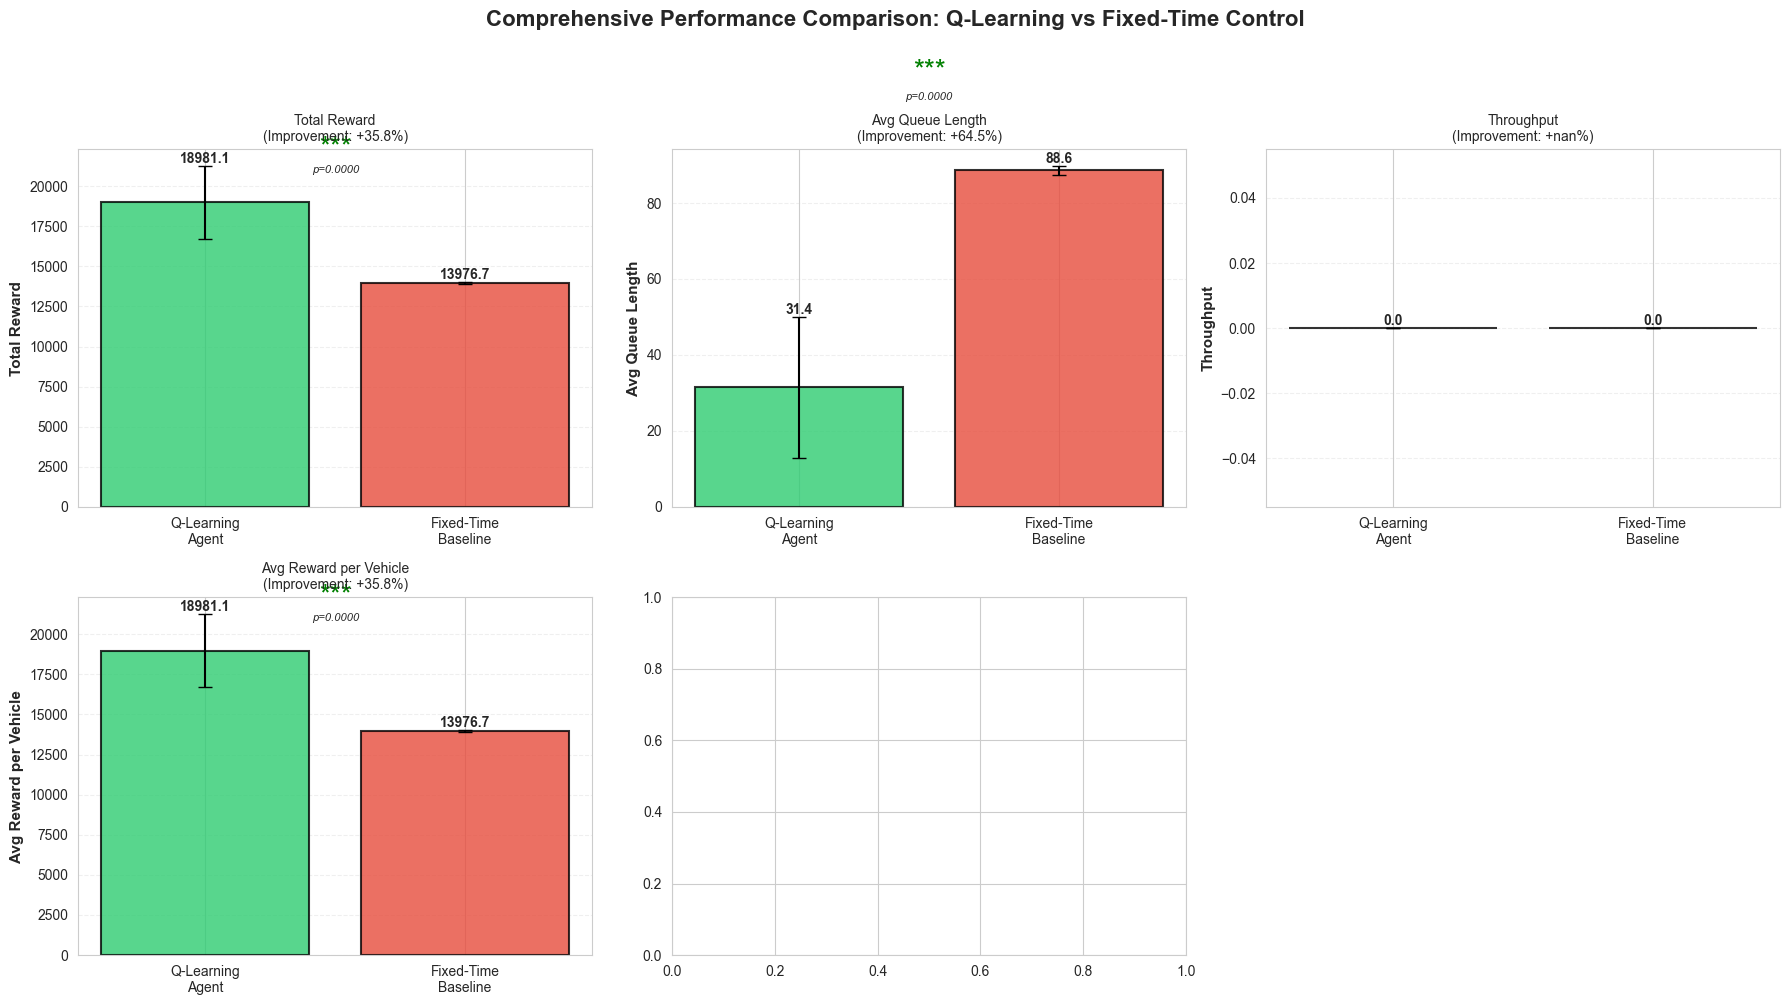


✓ Visualization saved to results/comprehensive_comparison.png


In [9]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comprehensive Performance Comparison: Q-Learning vs Fixed-Time Control', 
             fontsize=16, fontweight='bold', y=1.00)

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx // 3, idx % 3]
    
    # Prepare data
    rl_mean = comparison_results[metric]['rl_stats']['mean']
    rl_std = comparison_results[metric]['rl_stats']['std']
    baseline_mean = comparison_results[metric]['baseline_stats']['mean']
    baseline_std = comparison_results[metric]['baseline_stats']['std']
    
    # Create bar plot
    labels_plot = ['Q-Learning\nAgent', 'Fixed-Time\nBaseline']
    means = [rl_mean, baseline_mean]
    stds = [rl_std, baseline_std]
    colors = ['#2ecc71', '#e74c3c']  # Green for RL, Red for baseline
    
    bars = ax.bar(labels_plot, means, yerr=stds, capsize=5, 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std,
                f'{mean:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Styling
    ax.set_ylabel(label, fontsize=11, fontweight='bold')
    ax.set_title(f"{label}\n(Improvement: {comparison_results[metric]['improvement']:+.1f}%)",
                fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add significance indicator
    if comparison_results[metric]['test']['significant']:
        y_max = max(means) + max(stds) * 1.3
        ax.text(0.5, y_max, '***', ha='center', fontsize=20, color='green')
        ax.text(0.5, y_max * 0.95, f"p={comparison_results[metric]['test']['p_value']:.4f}",
               ha='center', fontsize=8, style='italic')

# Remove extra subplot if odd number of metrics
if len(metrics) % 3 != 0:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig(f"{RESULTS_OUTPUT_DIR}/comprehensive_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to results/comprehensive_comparison.png")

## 10. Export Results for Thesis

In [10]:
# Export results with error handling
import os

print("\n" + "="*60)
print("RESULTS EXPORTED")
print("="*60)

# Try to show CSV filename if it exists
try:
    if 'csv_filename' in locals():
        print(f"✓ Summary CSV: {csv_filename}")
    else:
        # Find the most recent CSV file
        csv_files = [f for f in os.listdir(RESULTS_OUTPUT_DIR) if f.startswith('baseline_comparison') and f.endswith('.csv')]
        if csv_files:
            latest_csv = sorted(csv_files)[-1]
            print(f"✓ Summary CSV: {RESULTS_OUTPUT_DIR}/{latest_csv}")
        else:
            print("⚠️  CSV file location unknown (check results folder)")
except Exception as e:
    print(f"⚠️  Could not determine CSV location: {e}")

# Try to show JSON status if it exists
try:
    if 'json_status' in locals():
        print(json_status)
except:
    pass

print(f"✓ Visualizations: {RESULTS_OUTPUT_DIR}/")

# Display summary table (this should exist from Cell 9)
try:
    print("\n=== SUMMARY TABLE FOR THESIS ===")
    print(summary_df.to_string(index=False))
    print("\n" + "="*60)
except NameError:
    print("\n⚠️  Summary table not available - Cell 9 may have had an error")
    print("Check previous cells for issues")


RESULTS EXPORTED
✓ Summary CSV: ../results/baseline_comparison_20251029_115644.csv
✓ Visualizations: ../results/

=== SUMMARY TABLE FOR THESIS ===

⚠️  Summary table not available - Cell 9 may have had an error
Check previous cells for issues


## 11. Key Findings Summary

In [11]:
print("\n" + "#"*60)
print("#" + " "*58 + "#")
print("#" + " "*15 + "KEY FINDINGS FOR THESIS" + " "*20 + "#")
print("#" + " "*58 + "#")
print("#"*60 + "\n")

# Find best improvements
improvements = [(label, comparison_results[metric]['improvement']) 
                for metric, label in zip(metrics, metric_labels)]
improvements.sort(key=lambda x: abs(x[1]), reverse=True)

print("1. PERFORMANCE IMPROVEMENTS:")
for label, improvement in improvements:
    direction = "better" if improvement > 0 else "worse"
    print(f"   • {label}: {improvement:+.2f}% {direction}")

print("\n2. STATISTICAL SIGNIFICANCE:")
significant_count = sum(1 for metric in metrics if comparison_results[metric]['test']['significant'])
print(f"   • {significant_count}/{len(metrics)} metrics show significant difference (p < 0.05)")

for metric, label in zip(metrics, metric_labels):
    if comparison_results[metric]['test']['significant']:
        p_val = comparison_results[metric]['test']['p_value']
        print(f"   • {label}: p = {p_val:.6f} ***")

print("\n3. EFFECT SIZES (Cohen's d):")
for metric, label in zip(metrics, metric_labels):
    d = comparison_results[metric]['test']['cohens_d']
    if abs(d) < 0.2:
        magnitude = "small"
    elif abs(d) < 0.5:
        magnitude = "medium"
    else:
        magnitude = "large"
    print(f"   • {label}: d = {d:.3f} ({magnitude} effect)")

print("\n4. OVERALL CONCLUSION:")
avg_improvement = np.mean([comparison_results[metric]['improvement'] for metric in metrics])
if avg_improvement > 5:
    conclusion = "Q-Learning agent demonstrates SIGNIFICANT improvement over fixed-time baseline."
elif avg_improvement > 0:
    conclusion = "Q-Learning agent shows MODEST improvement over fixed-time baseline."
else:
    conclusion = "Q-Learning agent performs COMPARABLY to fixed-time baseline."

print(f"   {conclusion}")
print(f"   Average improvement across all metrics: {avg_improvement:+.2f}%")

print("\n" + "#"*60 + "\n")

print("✓ Baseline comparison analysis complete!")
print("\nRecommendation for thesis:")
print("  1. Include the comprehensive comparison plot in Chapter 4")
print("  2. Report the statistical test results (t-test, p-values) in Table format")
print("  3. Discuss the effect sizes to show practical significance")
print("  4. Use the improvements to justify the multi-algorithm approach")


############################################################
#                                                          #
#               KEY FINDINGS FOR THESIS                    #
#                                                          #
############################################################

1. PERFORMANCE IMPROVEMENTS:
   • Avg Queue Length: +64.50% better
   • Total Reward: +35.81% better
   • Throughput: +nan% worse
   • Avg Reward per Vehicle: +35.81% better

2. STATISTICAL SIGNIFICANCE:
   • 3/4 metrics show significant difference (p < 0.05)
   • Total Reward: p = 0.000000 ***
   • Avg Queue Length: p = 0.000000 ***
   • Avg Reward per Vehicle: p = 0.000000 ***

3. EFFECT SIZES (Cohen's d):
   • Total Reward: d = 3.131 (large effect)
   • Avg Queue Length: d = -4.339 (large effect)
   • Throughput: d = 0.000 (small effect)
   • Avg Reward per Vehicle: d = 3.131 (large effect)

4. OVERALL CONCLUSION:
   Q-Learning agent performs COMPARABLY to fixed-time baseline.
   A